In [ ]:
# 필요한 라이브러리 불러오기
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

### 함수 정의(그래프 그리기 위함)

In [ ]:
# 그래프 그리기 위한 라이브러리 불러오기
import matplotlib.pyplot as plt

# 그래프 그리기 위한 함수 정의하기
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

### 학습/테스트 데이터셋 준비하기 (지도학습 - 라벨, 텍스트 쌍 이용)

In [ ]:
# IMDB movie review 데이터셋 준비 (지도학습 이용)
dataset, info = tfds.load('imdb_reviews', with_info = True, as_supervised=True)

# 학습 데이터셋과 테스트 데이터셋으로 나누기
train_dataset, test_dataset = dataset['train'], dataset['test']

In [ ]:
# 학습 데이터셋의 text와 label 출력해보기
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [ ]:
# buffer와 batch 사이즈 각각 10000, 64로 설정하기
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
# 학습 데이터셋 섞어주고 묶음(batch) 만들어주기
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# 테스트 데이터셋 묶음(batch) 만들어주기
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
# 학습 데이터셋의 text와 label 출력해보기
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'Admittedly, Parsifal is not an opera that can appeal to everyone, although it is a favourite of mine, Knappertsbusch, 1951, in particular. Syberberg\'s entire approach is so static. Whenever the music suddenly begins to swell ... Syberberg keeps the cast moving at the same pace. The takes on Amfortas and Klingsor are endless. Whatever happened to film editing? The result is physically exhausting to watch. The viewer is never spiritually transported. Your impulse is to rush home and play a recording again to confirm that Wagner got it right, Syberberg got it wrong. And that set decoration with those "clever" reminders of Wagner\'s anti-Semitism -- will there ever be a viewer of this film with no prior knowledge of Wagner?'
 b"As a kid, I loved this game. I played it a zillion times during Spring 1993 with my friend Andrew. I used to play Axel or Blaze and he would be Adam and no matter how often we played it we never seemed to get bored. Then Streets of Rage 2 came out. And w

### Encoder 구성하기 (문자열 토큰을 정수 인덱스로 변환)

In [ ]:
# 어휘(vocabulary) 크기 1000으로 설정하기
VOCAB_SIZE = 1000

# TextVectorization(문자열 토큰과 정수 인덱스 매핑) layer 이용하여 encoder 구성하기
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)

# 레이어의 어휘를 설정
tokenizer.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
# vocab(토큰) 20개 보여주기
vocab = np.array(tokenizer.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [ ]:
# 텍스트를 인덱스로 인코딩, 나머지 부분 zero padding
tokenized_example = tokenizer(example)[:3].numpy()
tokenized_example

array([[  1,   1,   7, ...,   0,   0,   0],
       [ 15,   4, 548, ...,   0,   0,   0],
       [ 10, 117,  22, ...,   0,   0,   0]])

In [ ]:
# 원래 문장(프랑스어)과 토큰화된 문장(영어) 출력하기
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[tokenized_example[n]]))
  print()

Original:  b'Admittedly, Parsifal is not an opera that can appeal to everyone, although it is a favourite of mine, Knappertsbusch, 1951, in particular. Syberberg\'s entire approach is so static. Whenever the music suddenly begins to swell ... Syberberg keeps the cast moving at the same pace. The takes on Amfortas and Klingsor are endless. Whatever happened to film editing? The result is physically exhausting to watch. The viewer is never spiritually transported. Your impulse is to rush home and play a recording again to confirm that Wagner got it right, Syberberg got it wrong. And that set decoration with those "clever" reminders of Wagner\'s anti-Semitism -- will there ever be a viewer of this film with no prior knowledge of Wagner?'
Round-trip:  [UNK] [UNK] is not an [UNK] that can [UNK] to everyone although it is a [UNK] of [UNK] [UNK] [UNK] in particular [UNK] entire [UNK] is so [UNK] [UNK] the music [UNK] begins to [UNK] [UNK] keeps the cast moving at the same [UNK] the takes on [

### 모델 만들기
1st layer. 텍스트를 인덱스로 변환

2nd layer. 인덱스를 embedding vector로 변환 -> embedding table

3rd layer. 문장을 앞에서부터 뒤로 살핌 (한방향으로)

4th layer. Relu 연산 수행 및 classification 수행

5th layer. classification 수행

In [ ]:
# 모델 구성하기
model = tf.keras.Sequential([
    # 첫번째 레이어 : encoder (텍스트를 인덱스로 변환)  
    tokenizer,
    # 두번째 레이어 : 임베딩 레이어 (인덱스를 featurre extraction과 같은 과정을 거쳐 embedding vector로 변환)
    tf.keras.layers.Embedding(
        input_dim=len(tokenizer.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    # 세번째 레이어 : 한방향(unidirectional) RNN 레이어 -> 한쪽으로만 순차적으로 문장을 살피므로 앞의 단어가 뒤의 문맥 이용 불가하다는 문제
    tf.keras.layers.LSTM(64),
    # 네번째 레이어 : RELU 연산 수행하는 레이어 (classification 수행)
    tf.keras.layers.Dense(64, activation='relu'),
    # 다섯번째 레이어 : classification 수행
    tf.keras.layers.Dense(1)
])

In [ ]:
# 각각의 레이어들이 마스킹 사용하는지 확인
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [ ]:
# sample_text 이용하여 테스트하기
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[-0.00017516]


In [ ]:
# padding 포함한 샘플 텍스트 이용하여 테스트하기
padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))

# sample_text 뒤에 padding('the'가 여러번)이 붙어도 위의 테스트 결과와 동일
print(predictions[0])

[-0.00017515]


### 모델 컴파일하기

In [ ]:
# 모델 컴파일하여 훈련 프로레스 구성하기
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

### 모델 학습시키기

In [ ]:
# 모델 학습시키기 (epochs 10으로 설정)
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 23s 48ms/step - loss: 0.6542 - accuracy: 0.5548 - val_loss: 0.5403 - val_accuracy: 0.7073
Epoch 2/10
391/391 [==============================] - 18s 45ms/step - loss: 0.4393 - accuracy: 0.7854 - val_loss: 0.3854 - val_accuracy: 0.8208
Epoch 3/10
391/391 [==============================] - 18s 46ms/step - loss: 0.3556 - accuracy: 0.8476 - val_loss: 0.3570 - val_accuracy: 0.8521
Epoch 4/10
391/391 [==============================] - 19s 46ms/step - loss: 0.3307 - accuracy: 0.8623 - val_loss: 0.3409 - val_accuracy: 0.8453
Epoch 5/10
391/391 [==============================] - 19s 46ms/step - loss: 0.3196 - accuracy: 0.8642 - val_loss: 0.3386 - val_accuracy: 0.8536
Epoch 6/10
391/391 [==============================] - 18s 46ms/step - loss: 0.3136 - accuracy: 0.8695 - val_loss: 0.3293 - val_accuracy: 0.8547
Epoch 7/10
391/391 [==============================] - 19s 46ms/step - loss: 0.3091 - accuracy: 0.8711 - val_loss: 0.3335 - val_accuracy:

### 테스트 데이터셋으로 테스트하기

In [ ]:
# 테스트 데이터셋으로 테스트하기
test_loss, test_acc = model.evaluate(test_dataset)

# test loss와 accuracy 출력
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 11s 29ms/step - loss: 0.3195 - accuracy: 0.8622
Test Loss: 0.31945326924324036
Test Accuracy: 0.8622400164604187


### accuracy와 loss 그래프로 나타내기

(0.0, 0.6716682046651841)

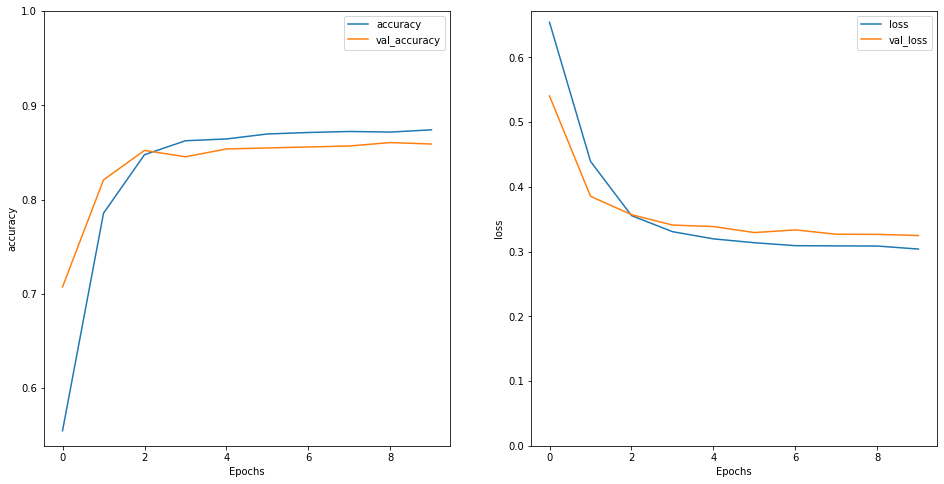

In [ ]:
# accuracy와 loss 그래프로 보여주기
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

# 그래프로 나타낸 결과, accuracy가 overfitting 없이 잘 학습된 것을 볼 수 있음

### 테스트 결과
테스트 결과 0.6570524로, 0.5이상이므로 positive함을 알 수 있음

In [ ]:
# sample_text로 테스트하기
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

# 테스트 결과 0.5이상으로, positive함

[[0.6570524]]
